<a href="https://colab.research.google.com/github/Prestigious-Power8/DeepLearningPneumoniaDetection/blob/main/Pediatric_Pneumonia_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.vgg19 import VGG19
from keras.datasets import cifar10
import cv2

In [ ]:

from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install kaggle


In [ ]:
import kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:

#kaggle dataset path
dataset_path = '/content/pediatric-pneumonia-chest-xray'



kaggle.api.dataset_download_files(dataset='andrewmvd/pediatric-pneumonia-chest-xray', path=dataset_path, unzip=True)


2023-12-22 03:47:44,814 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /api/v1/datasets/download/andrewmvd/pediatric-pneumonia-chest-xray?datasetVersionNumber=None


In [ ]:
!ls

test  train


In [ ]:
%cd /content/pediatric-pneumonia-chest-xray


/content/pediatric-pneumonia-chest-xray


In [ ]:
!ls


'Pediatric Chest X-ray Pneumonia'


In [ ]:
%cd /content/pediatric-pneumonia-chest-xray/'Pediatric Chest X-ray Pneumonia'
!ls


/content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia
test  train


In [ ]:
#path to point to the directory containing the dataset
dataset_path = '/content/pediatric-pneumonia-chest-xray'



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#paths to the 'train' and 'test' directories
train_path = '/content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train'
test_path = '/content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test'

#image dimensions and batch size
image_height, image_width = 224, 224
batch_size = 32

#ImageDataGenerators for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20
)

test_datagen = ImageDataGenerator(rescale=1./255)

#data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


#VGG16 model with pre-trained weights on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

#sequential model and add VGG16 as the base
model = Sequential()
model.add(vgg_model)

#layers in the VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False

#layers for classification on top of VGG16
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))  # dropout layer for regularization
model.add(Dense(1, activation='sigmoid'))  #output layer for binary classification

#learning rate
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.9)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

#training the model
history = model.fit(train_generator, epochs=15, validation_data=test_generator)


Epoch 1/15
164/164 [==============================] - 135s 817ms/step - loss: 0.3248 - accuracy: 0.8591 - val_loss: 0.3162 - val_accuracy: 0.8798
Epoch 2/15
164/164 [==============================] - 117s 716ms/step - loss: 0.2227 - accuracy: 0.9111 - val_loss: 0.3218 - val_accuracy: 0.8782
Epoch 3/15
164/164 [==============================] - 113s 687ms/step - loss: 0.1993 - accuracy: 0.9222 - val_loss: 0.2967 - val_accuracy: 0.8926
Epoch 4/15
164/164 [==============================] - 117s 715ms/step - loss: 0.1859 - accuracy: 0.9318 - val_loss: 0.2492 - val_accuracy: 0.9135
Epoch 5/15
164/164 [==============================] - 119s 724ms/step - loss: 0.1745 - accuracy: 0.9390 - val_loss: 0.3092 - val_accuracy: 0.8910
Epoch 6/15
164/164 [==============================] - 119s 726ms/step - loss: 0.1662 - accuracy: 0.9394 - val_loss: 0.2655 - val_accuracy: 0.9071
Epoch 7/15
164/164 [==============================] - 112s 685ms/step - loss: 0.1644 - accuracy: 0.9423 - val_loss: 0.2890 -

20/20 [==============================] - 5s 260ms/step - loss: 0.2558 - accuracy: 0.9119
Test Loss: 0.2557871639728546, Test Accuracy: 0.9118589758872986


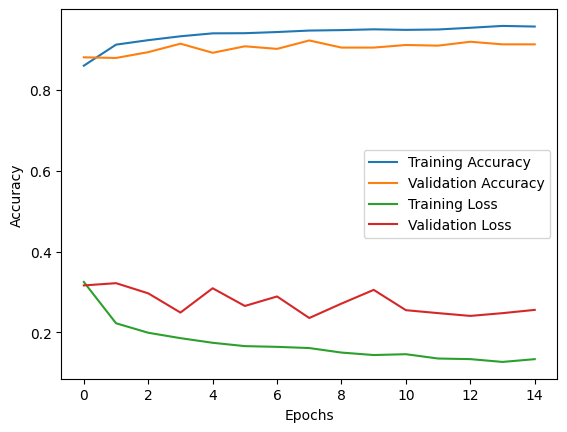

In [ ]:
#evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

#plotting the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

#get true labels
y_true = test_generator.classes

#calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

#print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

#print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["NORMAL", "PNEUMONIA"]))


20/20 [==============================] - 6s 289ms/step
Confusion Matrix:
[[ 74 160]
 [123 267]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.38      0.32      0.34       234
   PNEUMONIA       0.63      0.68      0.65       390

    accuracy                           0.55       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.53      0.55      0.54       624



20/20 [==============================] - 5s 274ms/step


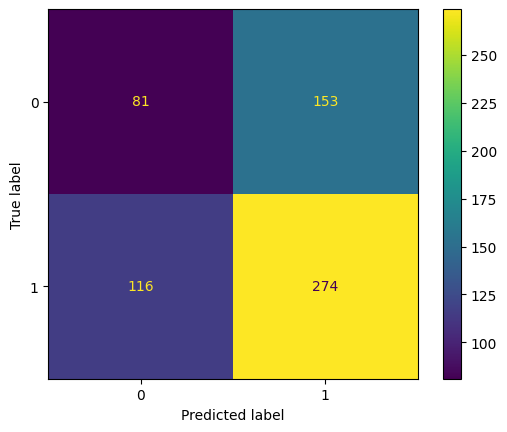

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

#generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

classes = [0, 1]

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

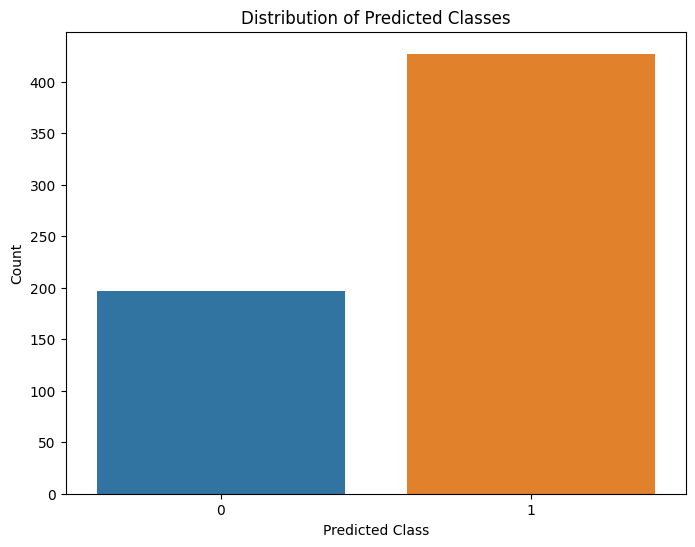

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#flatten the 2D array if needed
y_pred_classes_flat = np.ravel(y_pred_classes)


#bar plot of the data distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred_classes_flat)
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.show()
